In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from typing import Union, List, Tuple
import os

## Constants

In [71]:
M = 1 # kg
x0 = 2.8 # m
v0 = 0 # m/s
dt = 0.01
alpha = 0

## Helper Functions

In [72]:
def V(x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Custom Potential Energy dependent on position
    """
    return -np.exp(-x**2)-1.2*np.exp(-(x-2)**2)  # J

In [73]:
def derivative(func, x0: float, n: int = 1) -> float:
    """
    Computes derivative of a function f where x=x0, using recursion
    """
    dx = 1e-6
    if n == 1:
        dy = func(x0+dx) - func(x0)
        return dy/dx
    if n > 1:
        dy = derivative(func, x0 + dx, n-1) - derivative(func, x0, n-1)
        return dy / dx

In [74]:
def create_dir(path: str):
    """
    Creates directory if it doesn't exist already
    """
    if not os.path.exists(path):
        print(f"[INFO]::Creating a directory: {path}")
        os.makedirs(path)
        print(f"[SUCCESS]::directory creation completed!")

In [75]:
class PlotValue:
    def __init__(self, x: np.ndarray, y: np.ndarray, label: str = ""):
        self.x = x
        self.y = y
        self.label = label

## Solver

In [76]:

class Solver:
    def __init__(self, tmax: int, dt: float, alpha: float, mass: float):
        self.x = None
        self.v = None
        self.t = None
        self.alpha = None
        self.mass = None
        self.dt = None
        self.update_params(tmax, dt, alpha, mass)

    def update_params(self, tmax: int, dt: float, alpha: float, mass: float = M):
        num = int(tmax//dt)
        self.x = np.zeros(num)
        self.v = np.zeros(num)
        self.t = np.linspace(0, tmax, num=num)
        self.alpha = alpha
        self.mass = mass
        self.dt = dt

    def set_new_values(self, x: float, v: float, i):
        self.x[i] = x
        self.v[i] = v

    def get_new_values(self, i: int):
        return self.x[i], self.y[i]



## Euler Solver

In [77]:
class Euler(Solver):
    def __init__(self, tmax: int, dt: float, alpha: float, mass: float = M):
        super().__init__(tmax, dt, alpha, mass)

    def get_next_step(self, i: int):
        new_x = self.x[i] + self.v[i] * self.dt
        new_y = self.v[i] - 1 / self.mass * derivative(V, self.x[i]) * self.dt - self.alpha * self.v[i] * self.dt
        return new_x, new_y
    
    def calculate(self):
        for i in range(len(self.t)):
            if i == 0:
                self.set_new_values(x0, v0, 0)
                continue
            
            x, v = self.get_next_step(i-1)
            self.set_new_values(x, v, i)

## Trapezoid Solver

In [78]:
class Trapezoid(Solver):
    def __init__(self, tmax: int, dt: float, alpha: float, mass: float = M):
        super().__init__(tmax, dt, alpha, mass)

    def f1(self, xnext: float, vnext: float, i: int) -> float:
        return xnext - self.x[i] -vnext*self.dt/2 - self.v[i]*dt/2

    def f2(self, xnext: float, vnext: float, i: int) -> float:
        return vnext - self.v[i] - (-1/self.mass*derivative(V, xnext)-alpha*vnext)*self.dt/2 - (-1/self.mass*derivative(V, self.x[i])-alpha*self.v[i])*dt/2

    def get_b(self, xnext, vnext, i: int):
        return -np.array([self.f1(xnext, vnext, i), self.f2(xnext, vnext, i)])

    def get_A(self, xnext: float) -> np.ndarray:
        A = np.array([
            [1, -self.dt / 2],
            [self.dt / (2 * self.mass) * derivative(V, xnext, 2),
             1 + self.dt / 2 * self.alpha],
        ])
        return A

    def get_next_step(self, i: int) -> Tuple[float, float]:
        
        eps = 1e-3
        X = np.array([10.0, 10.0])  # x_mu, v_mu

        b = self.get_b(X[0], X[1], i-1)
        
        while abs(b[0]) > eps and abs(b[1]) > eps:

            solve_x = np.linalg.solve(self.get_A(X[0]
            ), b)
            X += solve_x
            b = self.get_b(X[0], X[1], i-1)
        return X[0], X[1]
    
    def calculate(self):
        for i in range(len(self.t)):
            if i == 0:
                self.set_new_values(x0, v0, 0)
                continue

            
            x, v = self.get_next_step(i)
            self.set_new_values(x, v, i)




## Plotter

In [79]:
class Plotter:
    def __init__(self, solver: Union[Euler, Trapezoid], dir: str):
        self.solver = solver
        self.dir = dir

    def get_KE(self) -> np.ndarray:
        return 0.5 * M * self.solver.v ** 2

    def get_V(self):
        return V(self.solver.x)

    def get_TE(self):
        return self.get_KE() + self.get_V()

    def plot_values(self, filename: str = "funcT"):
        fig, axes = plt.subplots(3, 1, sharex=True)
        values = [
            PlotValue(self.solver.t, self.solver.x, "Position"),
            PlotValue(self.solver.t, self.solver.v, "Velocity"),
            PlotValue(self.solver.t, self.get_KE(), "Kinetic Energy"),
            PlotValue(self.solver.t, self.get_V(), "Potential Energy"),
            PlotValue(self.solver.t, self.get_TE(), "Total Energy"),
        ]
        for ax, v in zip(axes[:2], values[:2]):
            ax.plot(v.x, v.y)
            ax.set_title(v.label)
        ax3 = axes[2]
        ax3.set_title("Energy")
        for v in values[2:]:
            ax3.plot(v.x, v.y, label = v.label)
            ax3.legend()
        
        fig.tight_layout()
    
        create_dir(self.dir)


        fig.savefig(f"{self.dir}/{filename}.png")
        plt.close()

    def plot_phase(self, filename: str = "phase"):

        fig, ax = plt.subplots(1, 1)
        ax.plot(self.solver.x, self.solver.v)
        ax.set_title("v(x)")
        

        fig.savefig(f"{self.dir}/{filename}.png")
        plt.close()



## Handler

In [80]:
class Handler:
    def __init__(self):
        self.dir: str = "images"

    def exercise(self, S: type, dt: float, alpha: float, dir: os.path):
        tmax = 30
        solver: Union[Euler, Trapezoid] = S(tmax, dt, alpha)
        solver.calculate()
        mplt = Plotter(solver, os.path.join(self.dir, dir))
        mplt.plot_values()
        for tmax in [100, 1000]:
            solver.update_params(tmax, dt, alpha)
            solver.calculate()
            mplt.plot_phase(f"phase{tmax}dt{dt}")

    def exercise1(self, method: type = Euler, dir: str = "euler"):

        dt_arr = [0.01, 0.001]
        for dt in dt_arr:
            
            self.exercise(method, dt, 0, os.path.join(dir, "ex1", f"dt{dt}"))

    def exercise2(self, method: type = Euler, dir: str = "euler"):
        dt = 0.01
        alphas = [0.5, 5, 201]
        for alpha in alphas:
            self.exercise(method, dt, alpha, os.path.join(dir, "ex2", f"alpha{alpha}"))

    def exercises(self, trapezoid: bool = False):
        if trapezoid:
            self.exercise1(Trapezoid, "trapezoid")
            self.exercise2(Trapezoid, "trapezoid")
        else:
            self.exercise1()
            self.exercise2()


    def run(self):
        self.exercises()
        self.exercises(trapezoid=True)


In [81]:
h = Handler()

In [82]:
h.run()

In [83]:
solver = Trapezoid(100, 0.01, 0.5)
solver.calculate()

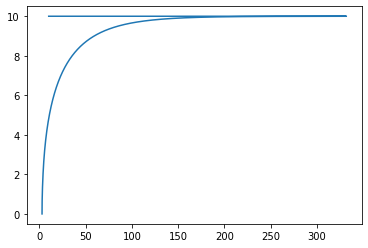

In [84]:
plt.plot(solver.x, solver.v)